In [1]:
import torch
import torch_geometric
import numpy as np
import pandas as pd
import sys
from tqdm import tqdm

sys.path.append('../')

from torch_geometric.contrib.nn.models import GRBCDAttack
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from engine.model.GCN import SimpleGCN

c:\Users\shyun\AppData\Local\anaconda3\envs\lig2023\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\shyun\AppData\Local\anaconda3\envs\lig2023\Lib\site-packages\torch_geometric\contrib\__init__.py:8: UserWarning: 'torch_geometric.contrib' contains experimental code and is subject to change. Please use with caution.
  warnings.warn(


In [2]:
model = torch.load('../data/checkpoint/simpleGCN.pt')
attack = GRBCDAttack(model , 10, allow_unused =True)

In [3]:
dataset = Planetoid('./Cora', 'Cora', pre_transform=NormalizeFeatures())

trainData = dataset
testData = dataset

In [4]:
print(dataset[0])
print(dataset.x.shape)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
torch.Size([2708, 1433])


In [5]:
minBudget = []
pred = model(dataset.x, dataset.edge_index).argmax(dim = 1)
for d in tqdm(range(len(trainData.x))):
    flag  = True
    budget = 1
    if pred[d] != dataset.y[d]:
        minBudget.append(0)
        continue
    while flag:
        pertubed, fl = attack.attack(dataset.x, dataset.edge_index, dataset.y, budget, d)
        ppred = model(dataset.x, pertubed).argmax(dim = 1)
        if pred[d] != ppred[d]:
            minBudget.append(budget)
            flag = False
        elif budget > 125:
            minBudget.append(-1)
            flag = False
        else:
            budget = budget + 5

100%|██████████| 2708/2708 [10:48:20<00:00, 14.37s/it]  


In [6]:
import pickle
with open('../data/result/coraBudget.pkl', 'wb') as f:
    pickle.dump(minBudget, f)

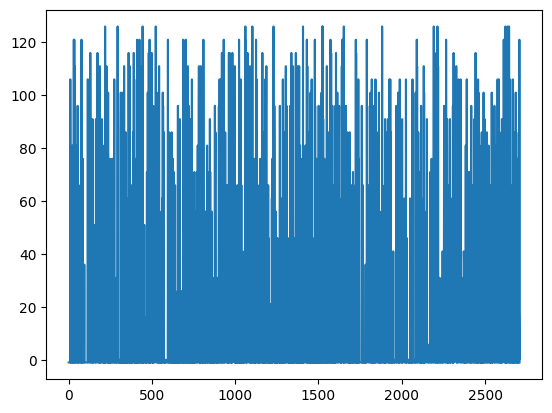

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(len(minBudget)), minBudget)
plt.show()

over 125:  1331
wrong answer:  641


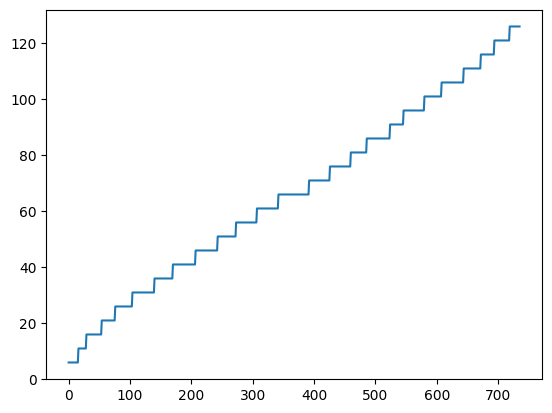

In [17]:
of = 0
uf = 0
normal = []
for x in minBudget:
    if x == 0:
        uf = uf + 1
    elif x == -1:
        of = of + 1
    else:
        normal.append(x)
print('over 125: ', of)
print('wrong answer: ', uf)
normal.sort()
plt.plot(range(len(normal)), normal)
plt.show()

In [14]:
print(normal[0])

IndexError: list index out of range